# Preprocessing

In [1]:
import tensorflow as tf
import os, shutil, glob
import numpy as np
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

model = VGG16(weights='imagenet', include_top=False)

# Variables
base_dir = 'data'
raw_dir = os.path.join(base_dir, "raw")
tar_dir = os.path.join(base_dir, 'clustering')
if os.path.exists(tar_dir):
    shutil.rmtree(tar_dir)
os.mkdir(tar_dir)

datalist = []
masklist = glob.glob(os.path.join(raw_dir, '*_mask.png'))
resultlist = glob.glob(os.path.join(raw_dir, '*_result.png'))
for i in masklist:
    datalist.append(i[:-9]+'.png')

# Loop over files and get features
resultlist.sort()
featurelist = []
for imagepath in tqdm(resultlist):
    img = Image.open(imagepath).convert("RGB")
    img_data = np.array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = np.array(model.predict(img_data))
    featurelist.append(features.flatten())

100%|██████████| 56/56 [00:04<00:00, 12.19it/s]


# Clustering

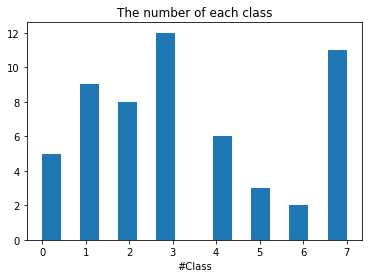

56it [00:00, 756.07it/s]


In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

try:
    shutil.rmtree(tar_dir)
    os.mkdir(tar_dir)
except:
    pass

number_clusters = 8
kmeans = KMeans(n_clusters=number_clusters, random_state=0).fit(np.array(featurelist))
plt.figure()
plt.hist(kmeans.labels_, bins=number_clusters*2)
plt.title("The number of each class")
plt.xlabel("#Class")
plt.show()

# Copy images renamed by cluster 
# Check if target dir exists
try:
    shutil.rmtree(tar_dir)
except OSError:
    pass
try:
    os.makedirs(tar_dir)
except OSError:
    pass
# Copy with cluster name
for i, m in tqdm(enumerate(kmeans.labels_)):
    shutil.copy(resultlist[i], os.path.join(tar_dir, str(m) + "_" + str(i) + ".png"))

# Splitting dataset

In [3]:
from random import choice


train_dir = os.path.join(base_dir,'train')
test_dir = os.path.join(base_dir,'test')

try:
    shutil.rmtree(train_dir)
    shutil.rmtree(test_dir)
except OSError:
    pass
try:
    os.mkdir(train_dir)
    os.mkdir(os.path.join(train_dir,'image'))
    os.mkdir(os.path.join(train_dir,'label'))
    os.mkdir(os.path.join(train_dir,'result'))
    os.mkdir(test_dir)
    os.mkdir(os.path.join(test_dir,'image'))
    os.mkdir(os.path.join(test_dir, "label"))
    os.mkdir(os.path.join(test_dir, "results"))
except OSError:
    pass

labels = kmeans.labels_
testrate = 0.2
# testset_num = round(testrate*len(filelist))
testset_num = 15
count = 0
check = True
while check:
    for i in range(number_clusters):   
        idxs = np.ndarray.tolist(np.where(labels==i)[0])
        if not idxs:
            continue
        idx = choice(idxs)
        shutil.copy(datalist[idx], os.path.join(test_dir, 'image', str(count)+".png"))
        shutil.copy(masklist[idx], os.path.join(test_dir, 'label', str(count)+".png"))
        shutil.copy(resultlist[idx], os.path.join(test_dir, 'results', str(count)+".png"))
        datalist.pop(idx)
        masklist.pop(idx)
        resultlist.pop(idx)
        labels = np.delete(labels,idx)
        count += 1
        if count >= testset_num:
            check = False
            break
for i in range(len(resultlist)):
    shutil.copy(datalist[i], os.path.join(train_dir,'image', str(i)+".png"))
    shutil.copy(masklist[i], os.path.join(train_dir,'label', str(i)+".png"))
    shutil.copy(resultlist[i], os.path.join(train_dir,'result', str(i)+".png"))